<div align='center'>
  <font size='8'>PROJECT S&P 500 UNSUPERVISED MACHINE LEARNING TRADING STRATEGY</font>
</div>


<font color='violet' size='6'> 1. Import essential libraries and wrangling data

In [10]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

warnings.filterwarnings('ignore')




In [89]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-12-31'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*9)

df = yf.download(tickers=symbols_list, start=start_date, end=end_date, auto_adjust=False).stack()






df





[*********************100%***********************]  503 of 503 completed


Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2016-01-04 A        37.791359   40.689999   41.189999   40.340000   41.060001   
           AAPL     23.834381   26.337500   26.342501   25.500000   25.652500   
           ABBV     38.972477   57.610001   58.320000   56.400002   58.060001   
           ABT      36.044079   42.930000   44.049999   42.500000   43.939999   
           ACGL     21.823122   22.950001   23.219999   22.616667   22.940001   
...                       ...         ...         ...         ...         ...   
2024-12-30 XYL     115.920494  116.279999  116.800003  115.160004  116.459999   
           YUM     132.892029  133.520004  134.410004  133.000000  134.130005   
           ZBH     105.174667  105.400002  106.349998  104.650002  106.050003   
           ZBRA    383.850006  383.850006  386.959991  378.149994  385.059998   
           ZTS     161.751007  162.240005  164.050003  161.449997  163.889999   

Price                   Volume  
Date       Ticker               
2016-01-04 A         3287300.0  
           AAPL    270597600.0  
           ABBV     10308400.0  
           ABT      12227500.0  
           ACGL      1220700.0  
...                        ...  
2024-12-30 XYL        586800.0  
           YUM       1144600.0  
           ZBH       1532000.0  
           ZBRA       211300.0  
           ZTS       1531400.0  

[1109540 rows x 6 columns]

<font color='violet' size='6'>2. Calculate features and technical indicators for each stock</font>

- German-Klass Volatility
- RSI 
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

In [92]:
df['german_klass_vol'] = ((np.log(df['High']) - np.log(df['Low']))**2)/2-(2*np.log(2)-1) * ((np.log(df['Adj Close']) - np.log(df['Open']))**2)

df['rsi'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])

df['bb_mid'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])

df['bb_high'] = df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['High'],
                        low = stock_data['Low'],
                        close=stock_data['Close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['Adj Close'].apply(compute_macd)

df['dollar_volume'] = (df['Adj Close']*df['Volume'])/1e6

df


Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2016-01-04 A        37.791359   40.689999   41.189999   40.340000   41.060001   
           AAPL     23.834381   26.337500   26.342501   25.500000   25.652500   
           ABBV     38.972477   57.610001   58.320000   56.400002   58.060001   
           ABT      36.044079   42.930000   44.049999   42.500000   43.939999   
           ACGL     21.823122   22.950001   23.219999   22.616667   22.940001   
...                       ...         ...         ...         ...         ...   
2024-12-30 XYL     115.920494  116.279999  116.800003  115.160004  116.459999   
           YUM     132.892029  133.520004  134.410004  133.000000  134.130005   
           ZBH     105.174667  105.400002  106.349998  104.650002  106.050003   
           ZBRA    383.850006  383.850006  386.959991  378.149994  385.059998   
           ZTS     161.751007  162.240005  164.050003  161.449997  163.889999   

Price                   Volume  german_klass_vol        rsi    bb_low  \
Date       Ticker                                                       
2016-01-04 A         3287300.0         -0.002441        NaN       NaN   
           AAPL    270597600.0         -0.001559        NaN       NaN   
           ABBV     10308400.0         -0.060821        NaN       NaN   
           ABT      12227500.0         -0.014515        NaN       NaN   
           ACGL      1220700.0         -0.000616        NaN       NaN   
...                        ...               ...        ...       ...   
2024-12-30 XYL        586800.0          0.000092  35.375389  4.734173   
           YUM       1144600.0          0.000022  46.389790  4.877092   
           ZBH       1532000.0          0.000103  43.454504  4.656261   
           ZBRA       211300.0          0.000261  45.199475  5.946061   
           ZTS       1531400.0          0.000061  32.695556  5.077445   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
Date       Ticker                                                         
2016-01-04 A            NaN       NaN       NaN       NaN     124.231534  
           AAPL         NaN       NaN       NaN       NaN    6449.526324  
           ABBV         NaN       NaN       NaN       NaN     401.743881  
           ABT          NaN       NaN       NaN       NaN     440.728974  
           ACGL         NaN       NaN       NaN       NaN      26.639485  
...                     ...       ...       ...       ...            ...  
2024-12-30 XYL     4.807539  4.880905  0.594913 -1.682434      68.022146  
           YUM     4.915020  4.952947  0.705026 -0.549613     152.108216  
           ZBH     4.684597  4.712934 -0.585186 -0.319057     161.127590  
           ZBRA    5.992536  6.039010  0.233099 -0.346097      81.107506  
           ZTS     5.147555  5.217664  0.496544 -1.848716     247.705492  

[1109540 rows x 14 columns]

<font color='violet' size='6'>3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.</font>
- To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency

In [93]:

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'Volume', 'Open', 'High', 'Low', 'Close']]

data = (pd.concat([df.unstack('Ticker')['dollar_volume'].resample('M').mean().stack('Ticker').to_frame('dollar_volume'),
df.unstack('Ticker')[last_cols].resample('M').last().stack('Ticker')], axis=1)).dropna()

data




dollar_volume   Adj Close  german_klass_vol        rsi  \
Date       Ticker                                                           
2016-02-29 A           91.091126   34.689297         -0.002443  48.107940   
           AAPL      3526.898643   21.993843         -0.003444  48.335994   
           ABBV       341.198706   37.331024         -0.062417  47.896402   
           ABT        239.796826   32.731419         -0.012673  47.035009   
           ACGL        29.994184   21.534683         -0.000906  50.307244   
...                          ...         ...               ...        ...   
2024-12-31 XYL        165.610350  115.920494          0.000092  35.375389   
           YUM        207.903122  132.892029          0.000022  46.389790   
           ZBH        165.112289  105.174667          0.000103  43.454504   
           ZBRA       121.040691  383.850006          0.000261  45.199475   
           ZTS        415.741918  161.751007          0.000061  32.695556   

                     bb_low    bb_mid   bb_high       atr      macd  
Date       Ticker                                                    
2016-02-29 A       3.513723  3.562525  3.611328 -1.046759 -0.233846  
           AAPL    3.100535  3.125000  3.149464 -1.113324 -0.345765  
           ABBV    3.594527  3.642506  3.690485 -0.588495 -0.293597  
           ABT     3.459524  3.503088  3.546652 -0.863058 -0.403019  
           ACGL    3.086989  3.113903  3.140816 -0.726640 -0.147822  
...                     ...       ...       ...       ...       ...  
2024-12-31 XYL     4.734173  4.807539  4.880905  0.594913 -1.682434  
           YUM     4.877092  4.915020  4.952947  0.705026 -0.549613  
           ZBH     4.656261  4.684597  4.712934 -0.585186 -0.319057  
           ZBRA    5.946061  5.992536  6.039010  0.233099 -0.346097  
           ZTS     5.077445  5.147555  5.217664  0.496544 -1.848716  

[52455 rows x 9 columns]

- calculate 5-year rolling average of dollar volume for each stocks before filtering

In [94]:
data['dollar_volume']= (data.loc[:, 'dollar_volume'].unstack('Ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = data.groupby('Date')['dollar_volume'].rank(ascending=False)

data = data[data['dollar_vol_rank'] < 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1) 

data



Adj Close  german_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2017-01-31 AAPL     28.065048         -0.002223  67.547689  3.326669   
           ABBV     43.371571         -0.040392  49.245610  3.770607   
           ABT      36.185127         -0.004990  66.811115  3.552843   
           ACN     100.605461         -0.005932  41.080239  4.622141   
           ADBE    113.379997          0.000042  65.319533  4.650383   
...                       ...               ...        ...       ...   
2024-12-31 VZ       38.295414         -0.000512  33.994210  3.648898   
           WDAY    262.000000          0.000183  49.133109  5.545855   
           WFC      70.064095          0.000098  50.026244  4.234759   
           WMT      90.321968          0.000046  51.567981  4.514605   
           XOM     104.822395         -0.000027  28.107003  4.630141   

                     bb_mid   bb_high       atr      macd  
Date       Ticker                                          
2017-01-31 AAPL    3.355170  3.383672 -1.280937 -0.143110  
           ABBV    3.801805  3.833004 -1.286292 -0.323408  
           ABT     3.586126  3.619409 -1.252821  0.192666  
           ACN     4.637113  4.652086 -1.131920 -0.414370  
           ADBE    4.706909  4.763434 -1.401426  0.109240  
...                     ...       ...       ...       ...  
2024-12-31 VZ      3.712937  3.776976 -0.745636 -1.687830  
           WDAY    5.597234  5.648614  1.316589  0.267364  
           WFC     4.281302  4.327846  1.394345 -0.277863  
           WMT     4.545205  4.575805  3.137196  1.073081  
           XOM     4.701864  4.773587  0.122161 -2.716784  

[14304 rows x 8 columns]

<font color='violet' size='6'>4. Calculate Monthly Returns for different time horizons as features</font>
- To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags
- In this section we also clipping the extreme values in the model. The reason for that is there will be outliers of stocks throughout the years and if we put that into training the model, it will affect the model dramatically. So we want to model things that happened frequently

In [95]:
def calculate_returns(df):

    outlier_cutoff = 0.005 # 99.5 percentile

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['Adj Close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                    upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))  #This is using the formula of CAGR

    return df 

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data
                                


Adj Close  german_klass_vol        rsi    bb_low  \
Date       Ticker                                                      
2018-01-31 AAPL     39.344814         -0.001257  40.100614  3.694922   
           ABBV     82.313690         -0.044895  62.305728  4.227376   
           ABT      55.006325         -0.006449  69.274886  3.931741   
           ACN     144.842682         -0.003841  63.135320  4.952747   
           ADBE    199.759995          0.000156  65.801036  5.203949   
...                       ...               ...        ...       ...   
2024-12-31 VZ       38.295414         -0.000512  33.994210  3.648898   
           WDAY    262.000000          0.000183  49.133109  5.545855   
           WFC      70.064095          0.000098  50.026244  4.234759   
           WMT      90.321968          0.000046  51.567981  4.514605   
           XOM     104.822395         -0.000027  28.107003  4.630141   

                     bb_mid   bb_high       atr      macd  return_1m  \
Date       Ticker                                                      
2018-01-31 AAPL    3.735332  3.775743 -1.058460 -0.423076  -0.010637   
           ABBV    4.359301  4.491226  1.278733  1.803853   0.168699   
           ABT     3.990540  4.049340 -0.756532  0.955844   0.094397   
           ACN     4.976202  4.999657 -1.094307  0.271513   0.049709   
           ADBE    5.268046  5.332143 -1.027483  0.443552   0.139922   
...                     ...       ...       ...       ...        ...   
2024-12-31 VZ      3.712937  3.776976 -0.745636 -1.687830  -0.106901   
           WDAY    5.597234  5.648614  1.316589  0.267364   0.048042   
           WFC     4.281302  4.327846  1.394345 -0.277863  -0.075620   
           WMT     4.545205  4.575805  3.137196  1.073081  -0.018695   
           XOM     4.701864  4.773587  0.122161 -2.716784  -0.103425   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
Date       Ticker                                                          
2018-01-31 AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553  
           ABBV     0.079892   0.077893   0.081233   0.063580    0.054846  
           ABT      0.052610   0.048209   0.041483   0.040973    0.035516  
           ACN      0.041987   0.041220   0.039209   0.032852    0.030836  
           ADBE     0.049184   0.044779   0.053053   0.045588    0.048329  
...                      ...        ...        ...        ...         ...  
2024-12-31 VZ      -0.030491  -0.036112  -0.001475  -0.001122    0.009518  
           WDAY     0.058478   0.023436   0.026797  -0.004458   -0.004347  
           WFC      0.044421   0.078250   0.031067   0.024025    0.032528  
           WMT      0.052442   0.039763   0.050561   0.047477    0.047447  
           XOM     -0.044450  -0.031073  -0.011368  -0.007769    0.007507  

[12068 rows x 14 columns]

<font color='violet' size='6'>5. Download Fama-French Factors and calulate Rolling Factor Betas.</font>
- We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using lineat regression.
- The five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.
- We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.



In [113]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                   'famafrench', 
                   start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample("M").last().div(100)

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data




Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2018-01-31 AAPL    0.0557 -0.0317 -0.0128 -0.0075 -0.0091  -0.010637
           ABBV    0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.168699
           ABT     0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.094397
           ACN     0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.049709
           ADBE    0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.139922
...                   ...     ...     ...     ...     ...        ...
2024-12-31 VZ     -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.106901
           WDAY   -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.048042
           WFC    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.075620
           WMT    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.018695
           XOM    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.103425

[12068 rows x 6 columns]

Filter out stocks with less than 10 months of data

In [114]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 24]

factor_data = factor_data[factor_data.index.get_level_values('Ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
Date       Ticker                                                   
2018-01-31 AAPL    0.0557 -0.0317 -0.0128 -0.0075 -0.0091  -0.010637
           ABBV    0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.168699
           ABT     0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.094397
           ACN     0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.049709
           ADBE    0.0557 -0.0317 -0.0128 -0.0075 -0.0091   0.139922
...                   ...     ...     ...     ...     ...        ...
2024-12-31 VZ     -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.106901
           WDAY   -0.0317 -0.0387 -0.0295  0.0182 -0.0110   0.048042
           WFC    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.075620
           WMT    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.018695
           XOM    -0.0317 -0.0387 -0.0295  0.0182 -0.0110  -0.103425

[11920 rows x 6 columns]

- Calculate Rolling Factor Betas

In [115]:
betas =     (factor_data.groupby(level=1, 
                                group_keys=False)
            .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                        exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                        window =min(24, x.shape[0]),
                                        min_nobs=len(x.columns)+1)
            .fit(params_only=True)
            .params
            .drop('const', axis=1)))                            
betas

Mkt-RF       SMB       HML       RMW       CMA
Date       Ticker                                                  
2018-01-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-12-31 VZ      1.235714 -0.865787  0.814504  0.677693 -0.507865
           WDAY    0.956079 -1.328605  0.589887 -2.279251 -1.585646
           WFC     0.423110  0.044567  0.862769 -2.253026 -0.074450
           WMT     0.736723  0.332169 -0.563337  1.171111  0.738052
           XOM     0.715617  0.036277  0.277826  1.167957  0.717821

[11920 rows x 5 columns]

In [122]:
#factors = ['Mkt-RF', 'SMB', 'HML', 'RMW','CMA']


#we can only know the factors in the upcoming month in reality so we have to shift the data down to one month
#data = (data.join(betas.groupby("Ticker").shift()))


#data.loc[:, factors] = data.groupby('Ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('Adj Close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11920 entries, (Timestamp('2018-01-31 00:00:00'), 'AAPL') to (Timestamp('2024-12-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   german_klass_vol  11920 non-null  float64
 1   rsi               11920 non-null  float64
 2   bb_low            11920 non-null  float64
 3   bb_mid            11920 non-null  float64
 4   bb_high           11920 non-null  float64
 5   atr               11920 non-null  float64
 6   macd              11920 non-null  float64
 7   return_1m         11920 non-null  float64
 8   return_2m         11920 non-null  float64
 9   return_3m         11920 non-null  float64
 10  return_6m         11920 non-null  float64
 11  return_9m         11920 non-null  float64
 12  return_12m        11920 non-null  float64
 13  Mkt-RF            11920 non-null  float64
 14  SMB               11920 non-null  float64
 15  HML       

Now, we will decide on what ML model and approach to use for predictions etc.

<font color='violet' size='6'>6. For each month fit a K-Means Clustering Algorithms to group similar assets based on their features.</font>

K-Means Clustering
- You may want to initialise predefined centroids for each cluster based on your research
- For visualization purpose of this tutorial we will initially rely on the 'k-means++' initialization.
- Then we will pre-define our centroids for each clusters

In [133]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, 
                           random_state=0, 
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('Date', group_keys =False).apply(get_clusters)

data

german_klass_vol        rsi    bb_low    bb_mid   bb_high  \
Date       Ticker                                                              
2018-01-31 AAPL           -0.001257  40.100614  3.694922  3.735332  3.775743   
           ABBV           -0.044895  62.305728  4.227376  4.359301  4.491226   
           ABT            -0.006449  69.274886  3.931741  3.990540  4.049340   
           ACN            -0.003841  63.135320  4.952747  4.976202  4.999657   
           ADBE            0.000156  65.801036  5.203949  5.268046  5.332143   
...                             ...        ...       ...       ...       ...   
2024-12-31 VZ             -0.000512  33.994210  3.648898  3.712937  3.776976   
           WDAY            0.000183  49.133109  5.545855  5.597234  5.648614   
           WFC             0.000098  50.026244  4.234759  4.281302  4.327846   
           WMT             0.000046  51.567981  4.514605  4.545205  4.575805   
           XOM            -0.000027  28.107003  4.630141  4.701864  4.773587   

                        atr      macd  return_1m  return_2m  return_3m  \
Date       Ticker                                                        
2018-01-31 AAPL   -1.058460 -0.423076  -0.010637  -0.012944  -0.001992   
           ABBV    1.278733  1.803853   0.168699   0.079892   0.077893   
           ABT    -0.756532  0.955844   0.094397   0.052610   0.048209   
           ACN    -1.094307  0.271513   0.049709   0.041987   0.041220   
           ADBE   -1.027483  0.443552   0.139922   0.049184   0.044779   
...                     ...       ...        ...        ...        ...   
2024-12-31 VZ     -0.745636 -1.687830  -0.106901  -0.030491  -0.036112   
           WDAY    1.316589  0.267364   0.048042   0.058478   0.023436   
           WFC     1.394345 -0.277863  -0.075620   0.044421   0.078250   
           WMT     3.137196  1.073081  -0.018695   0.052442   0.039763   
           XOM     0.122161 -2.716784  -0.103425  -0.044450  -0.031073   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
Date       Ticker                                                         
2018-01-31 AAPL     0.021212   0.018481    0.028553  1.284629 -0.202119   
           ABBV     0.081233   0.063580    0.054846  0.453542  0.360362   
           ABT      0.041483   0.040973    0.035516  0.815784 -0.131632   
           ACN      0.039209   0.032852    0.030836  1.191711 -0.192007   
           ADBE     0.053053   0.045588    0.048329  1.245772 -0.446709   
...                      ...        ...         ...       ...       ...   
2024-12-31 VZ      -0.001475  -0.001122    0.009518  0.885084 -0.601238   
           WDAY     0.026797  -0.004458   -0.004347  0.760261 -1.023756   
           WFC      0.031067   0.024025    0.032528  0.723369 -0.312743   
           WMT      0.050561   0.047477    0.047447  0.844672  0.175280   
           XOM     -0.011368  -0.007769    0.007507  0.614502  0.031073   

                        HML       RMW       CMA  cluster  
Date       Ticker                                         
2018-01-31 AAPL   -0.591016  0.506745  0.388324        1  
           ABBV   -0.044052  0.294847  0.378793        0  
           ABT    -0.492534  0.178973  1.050269        2  
           ACN    -0.269405  0.184067  0.094076        0  
           ADBE   -0.208188 -0.004253 -0.507797        0  
...                     ...       ...       ...      ...  
2024-12-31 VZ      0.296357  0.508945  0.278688        2  
           WDAY    0.151963 -2.488470 -0.729054        0  
           WFC     1.430126 -2.012819 -1.095362        0  
           WMT    -0.332479  1.278275  0.295498        0  
           XOM     0.205460  1.178935  0.728171        2  

[11920 rows x 19 columns]

In [145]:
def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]
   
    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return




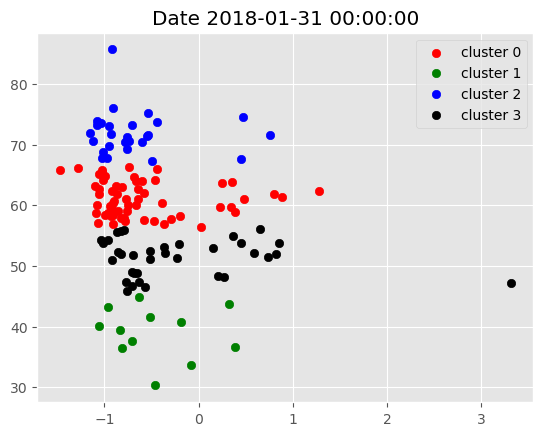

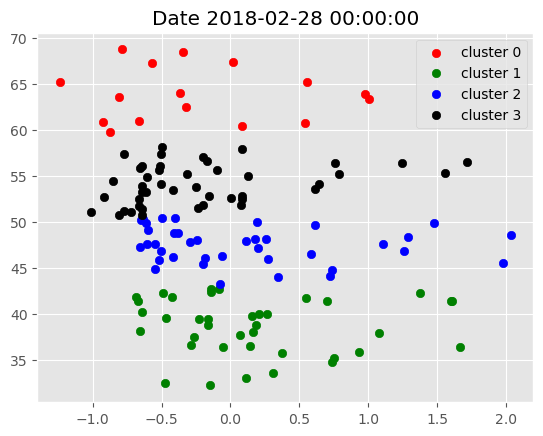

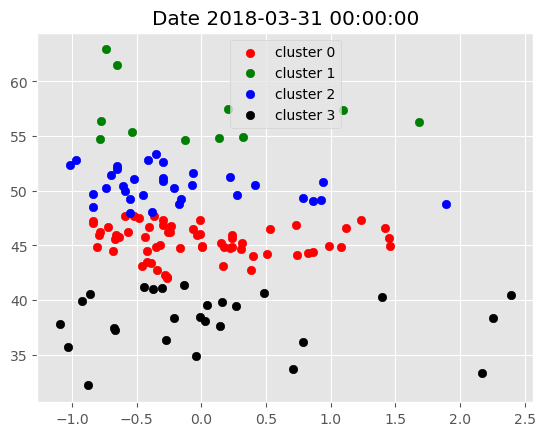

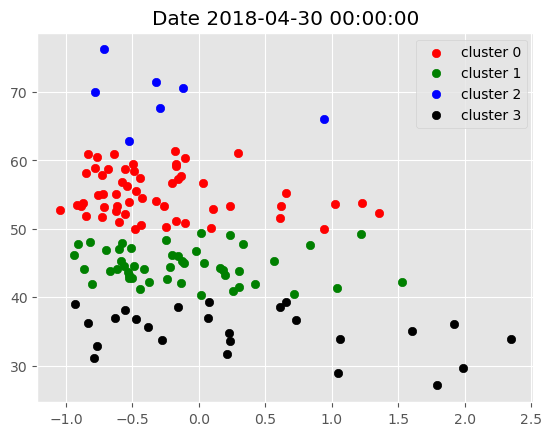

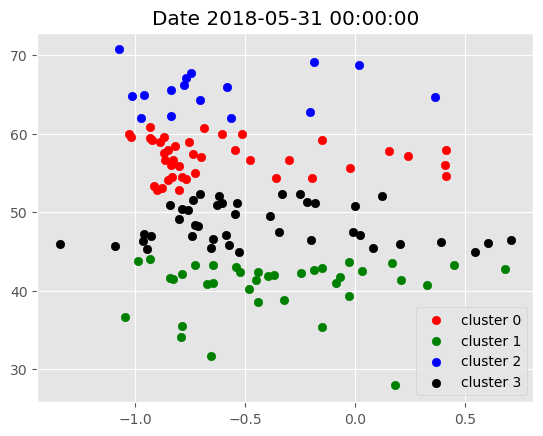

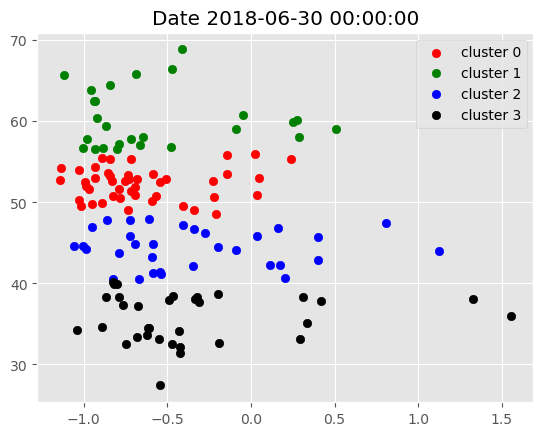

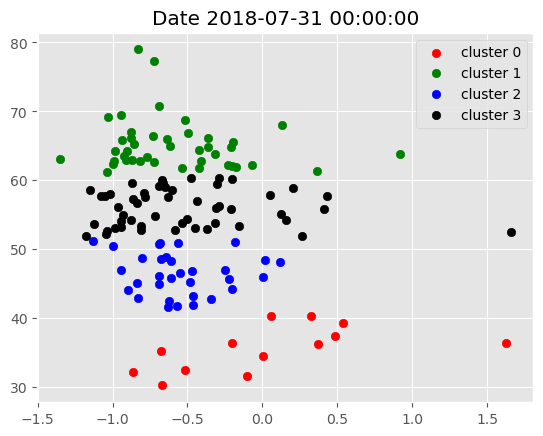

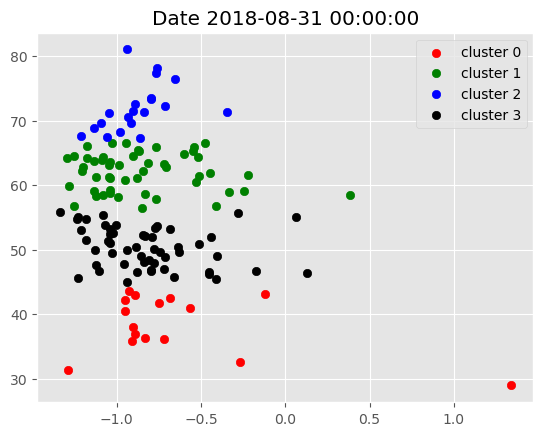

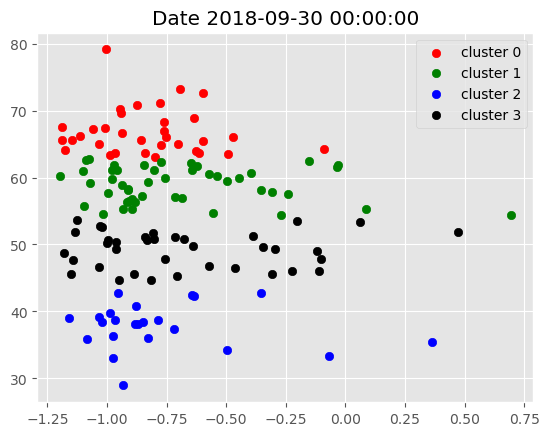

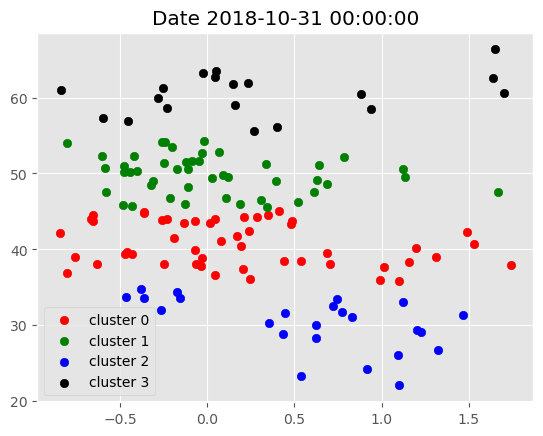

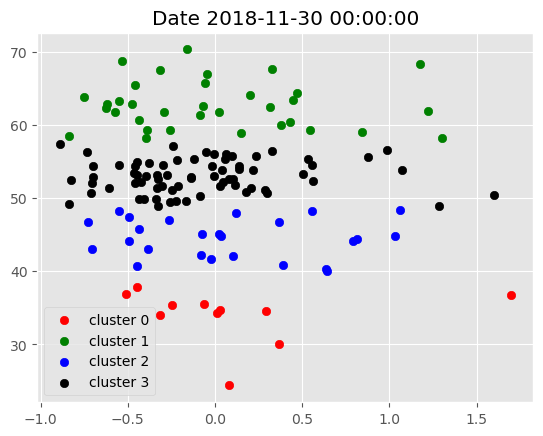

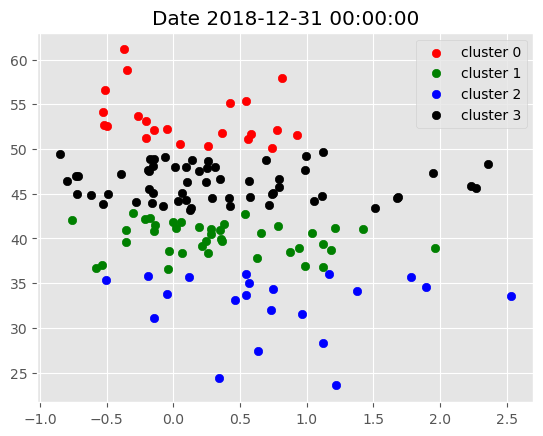

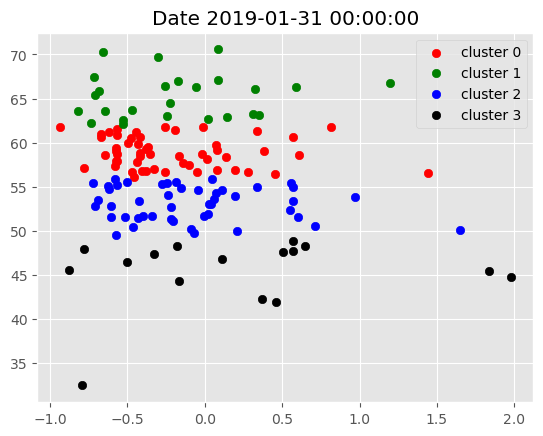

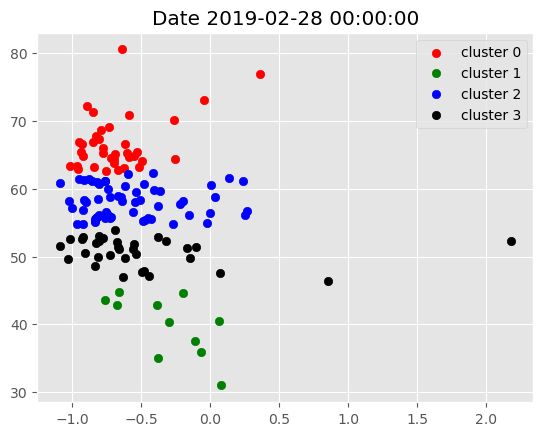

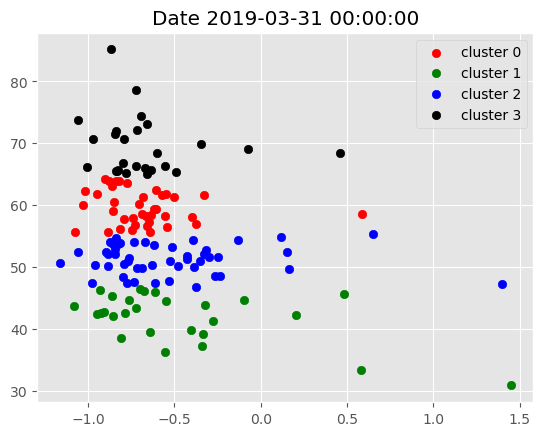

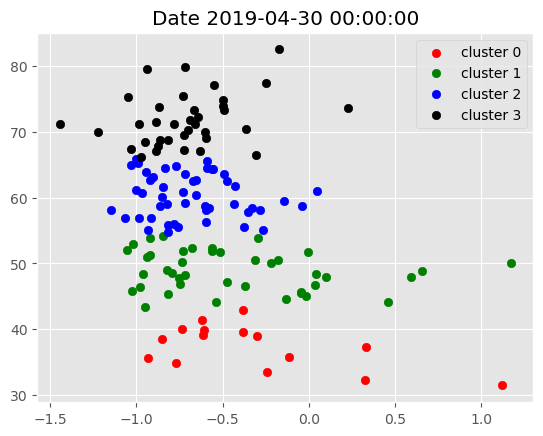

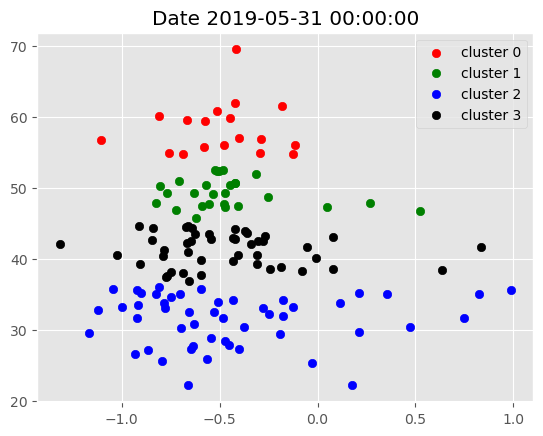

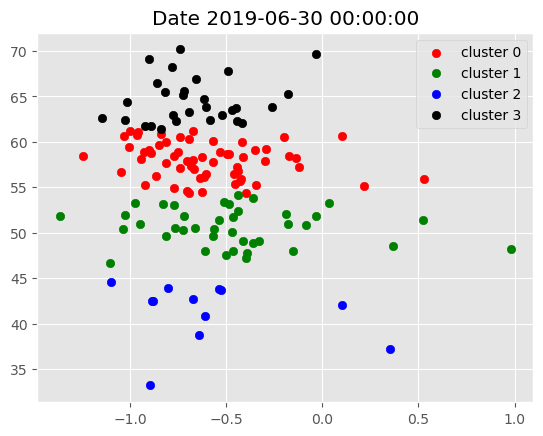

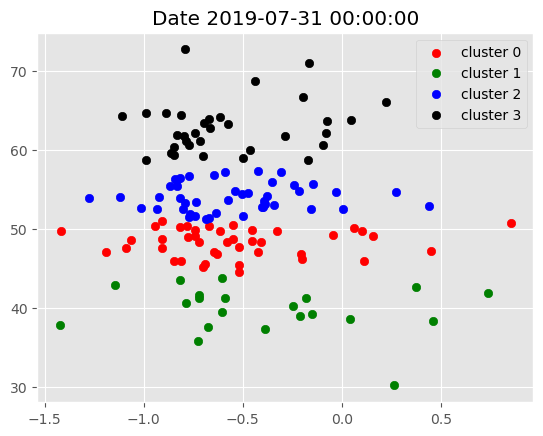

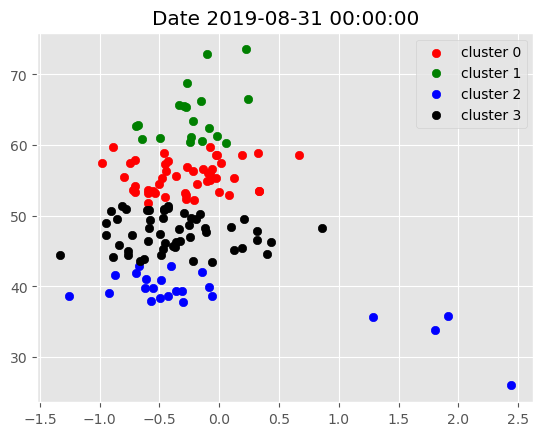

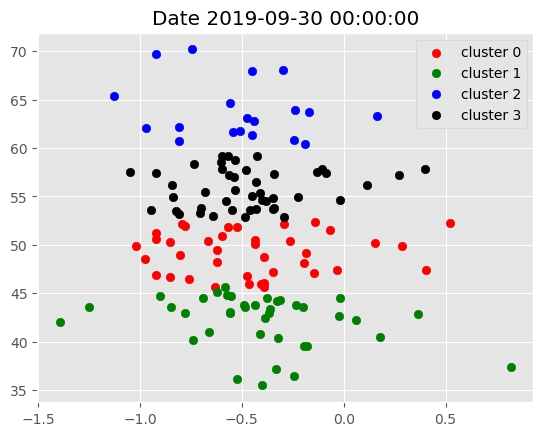

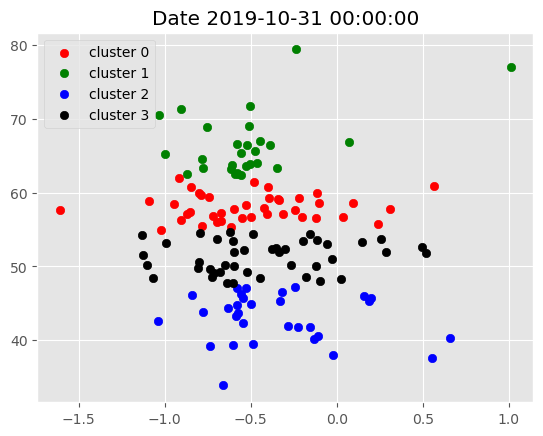

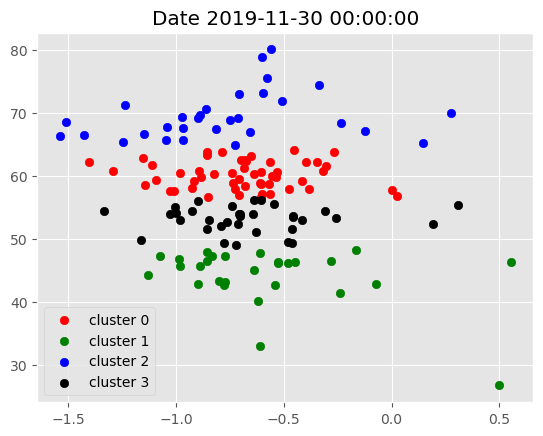

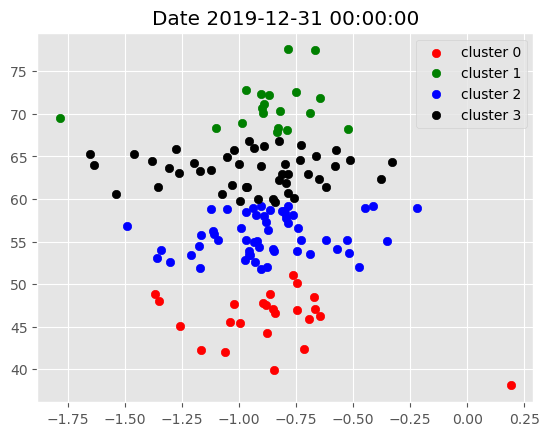

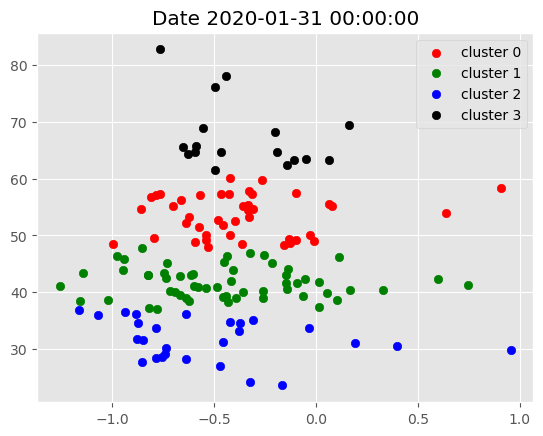

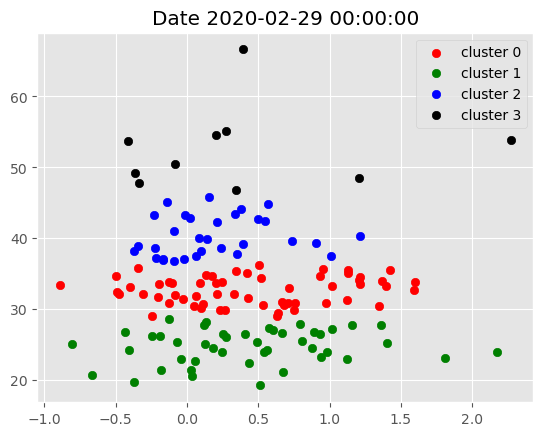

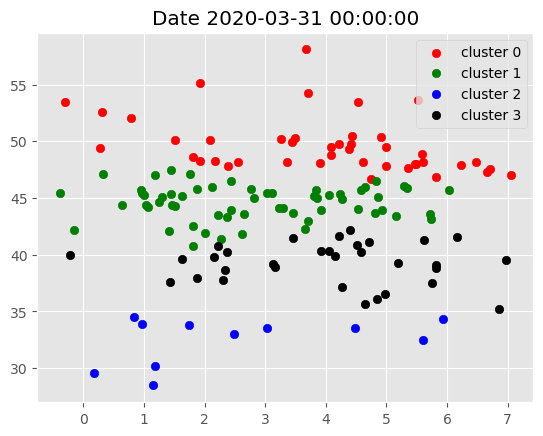

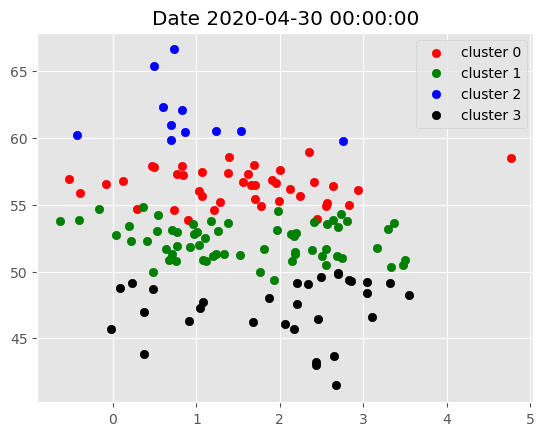

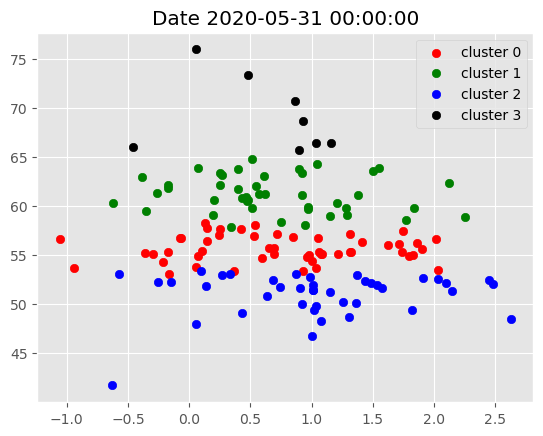

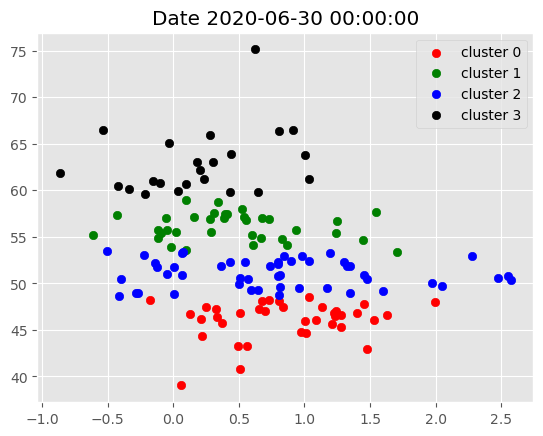

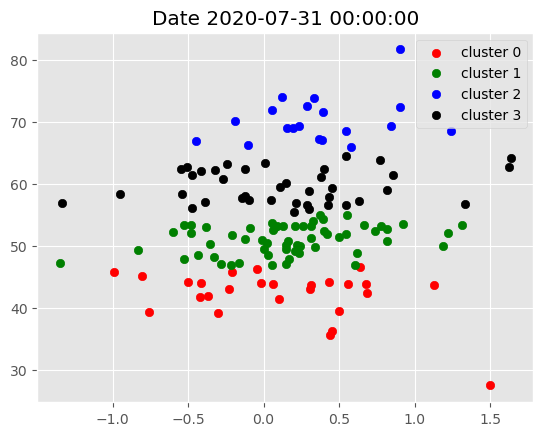

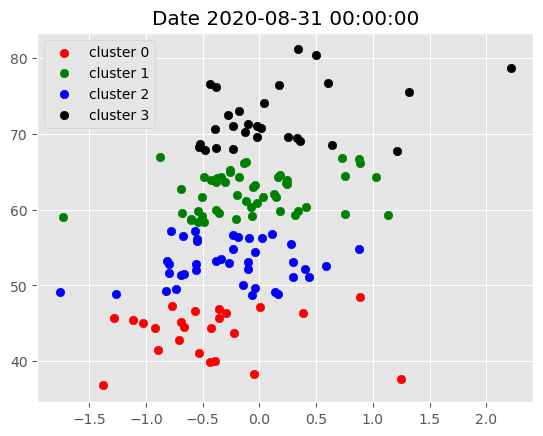

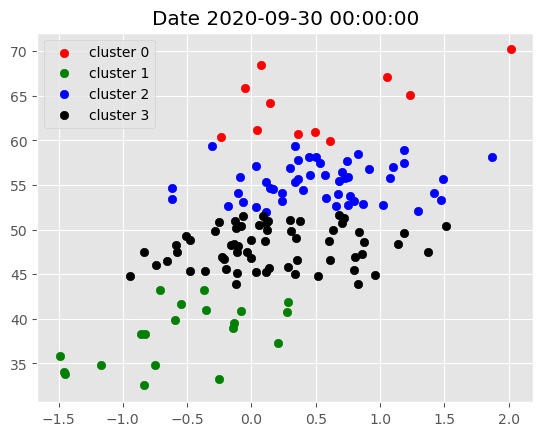

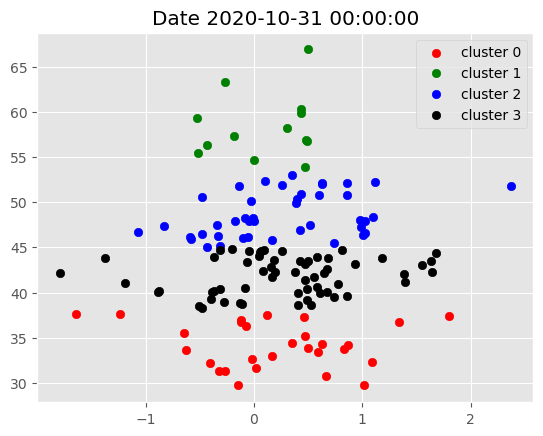

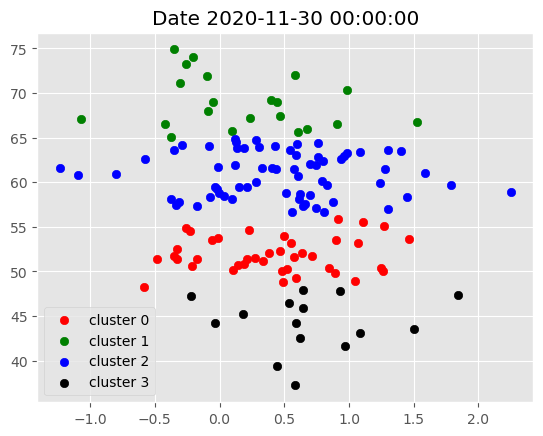

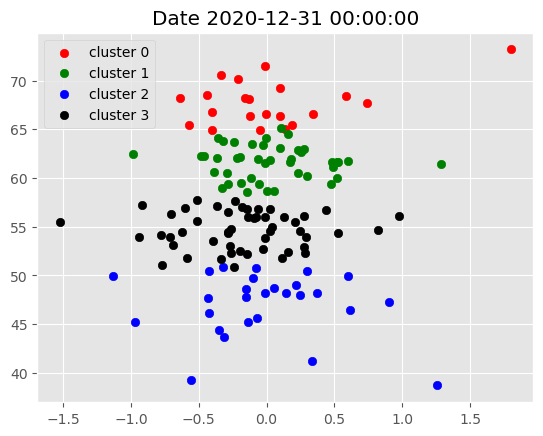

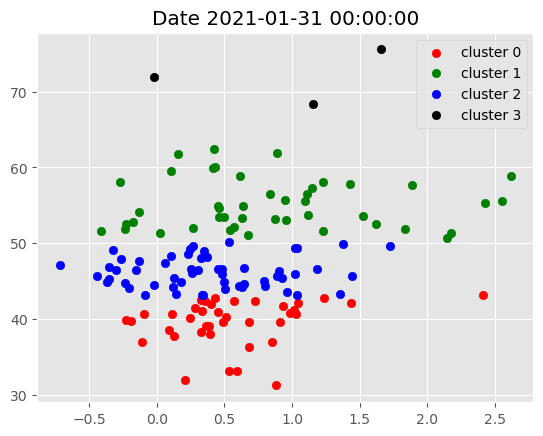

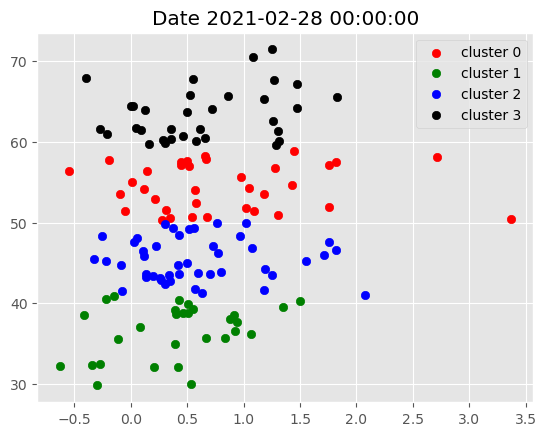

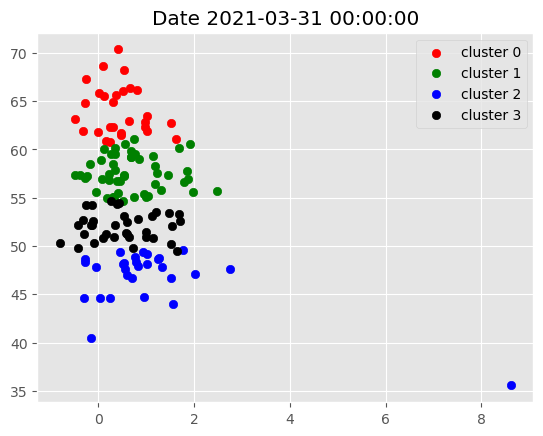

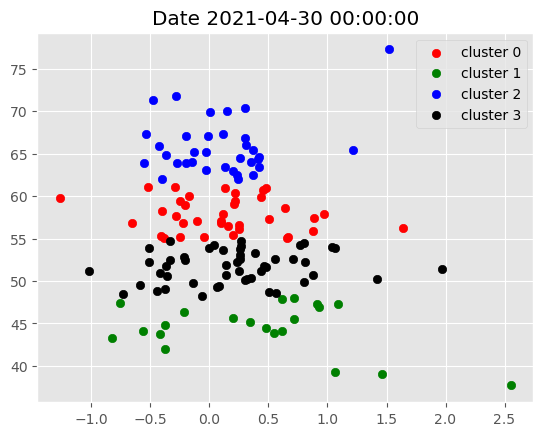

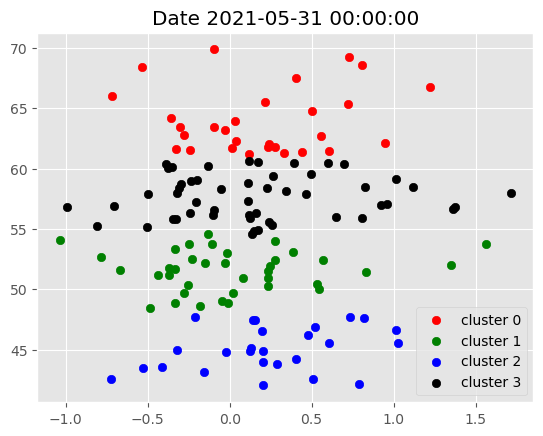

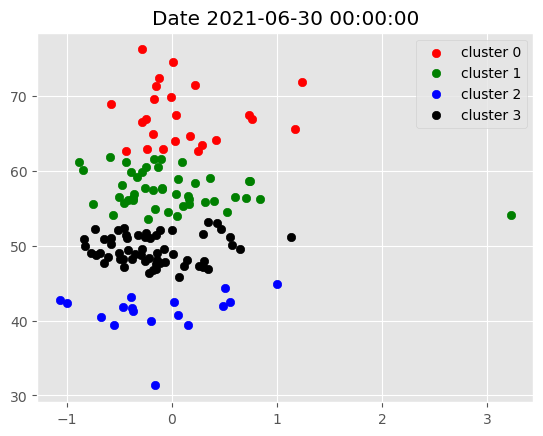

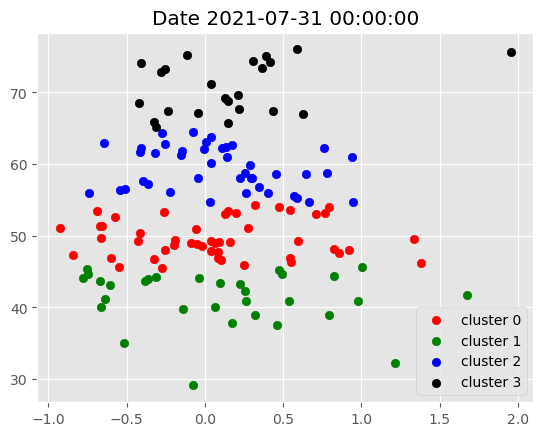

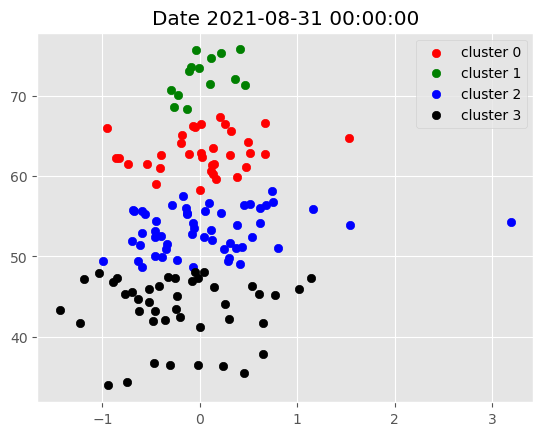

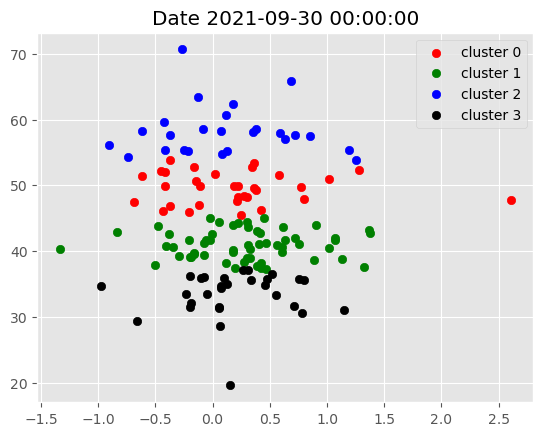

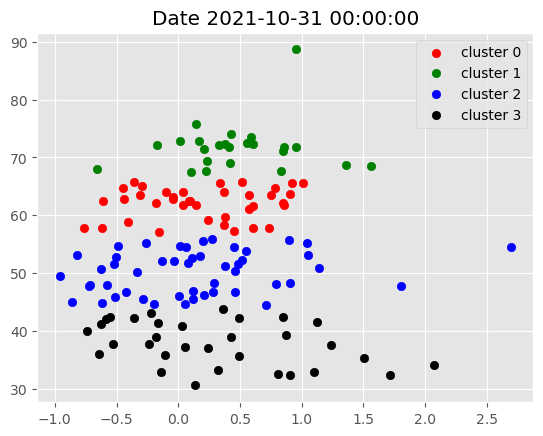

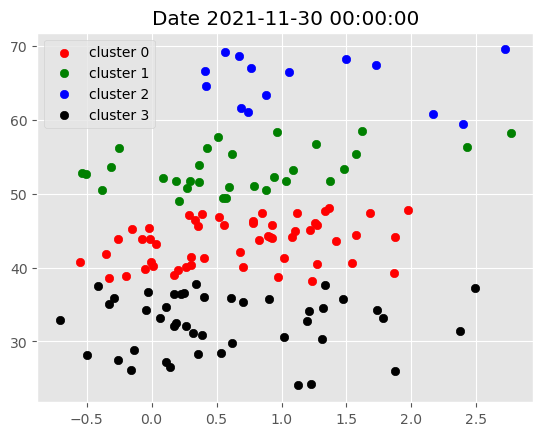

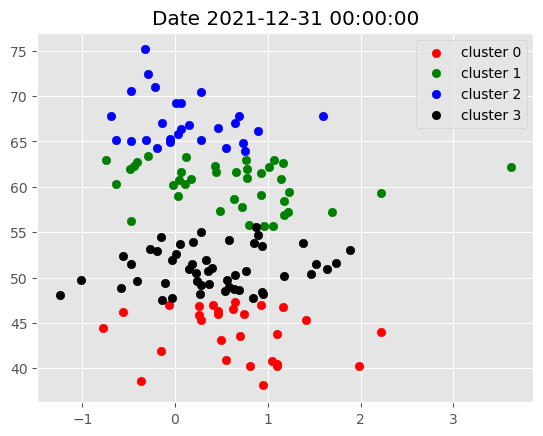

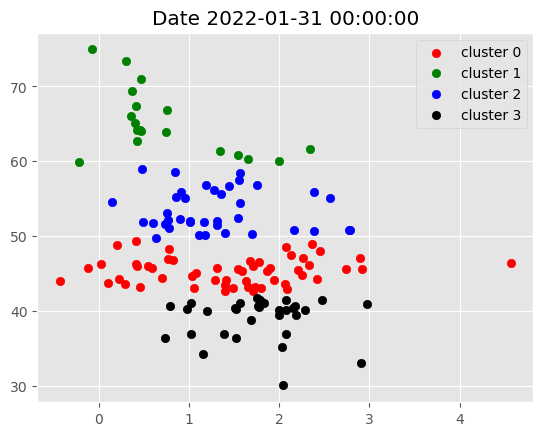

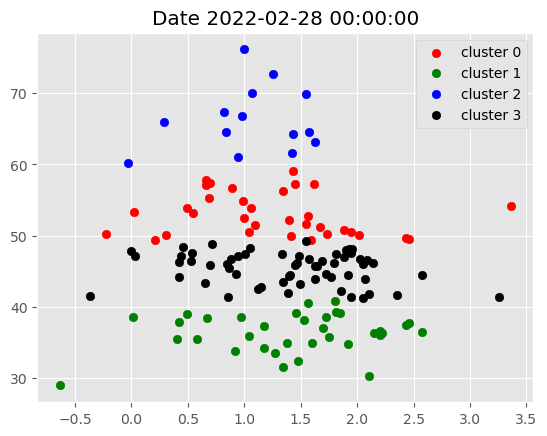

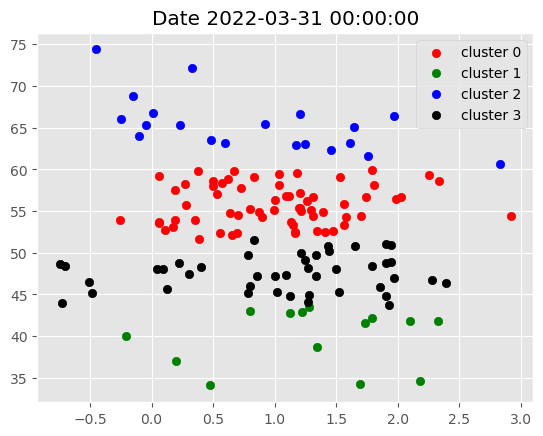

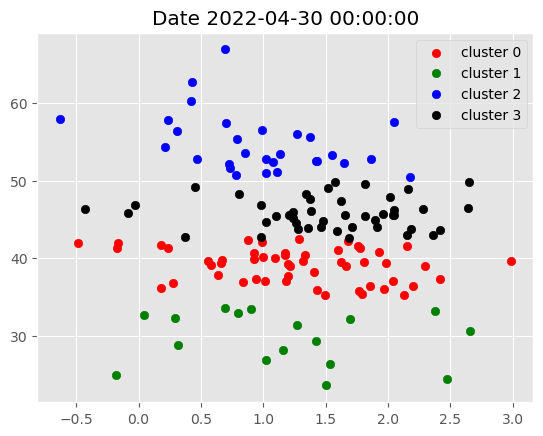

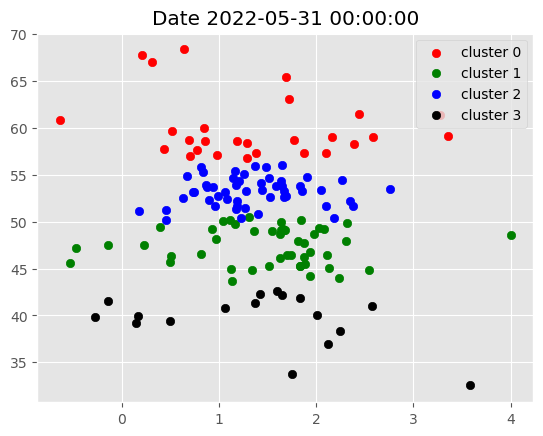

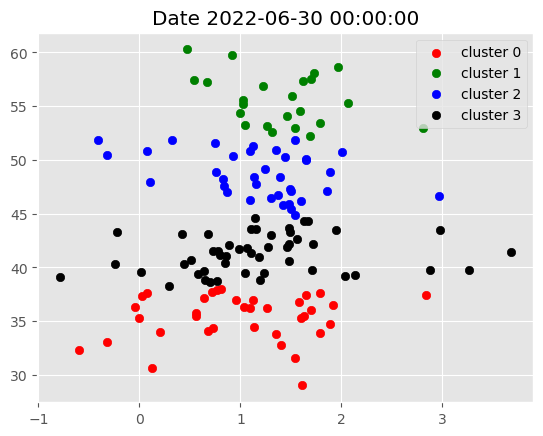

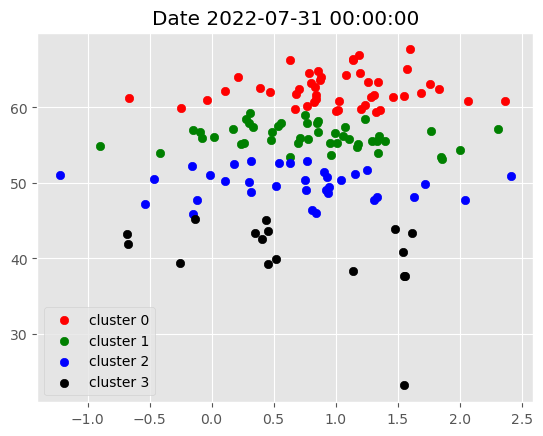

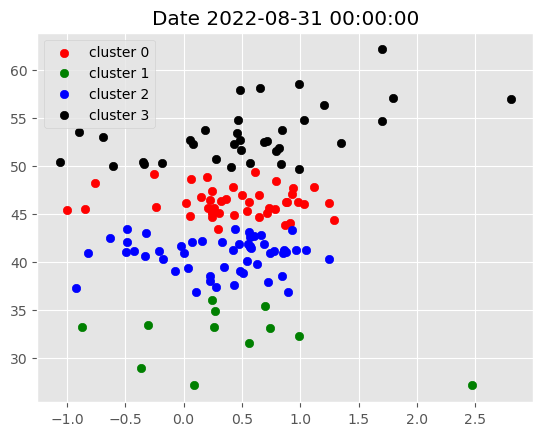

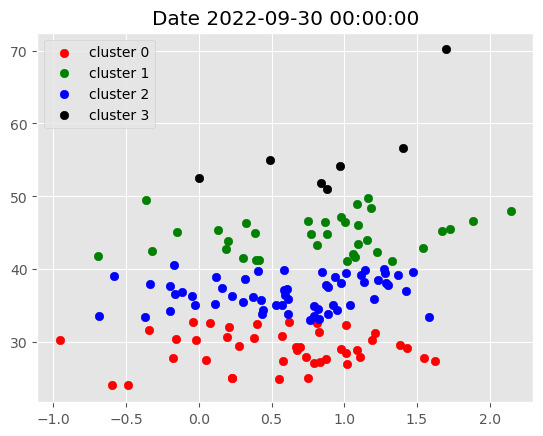

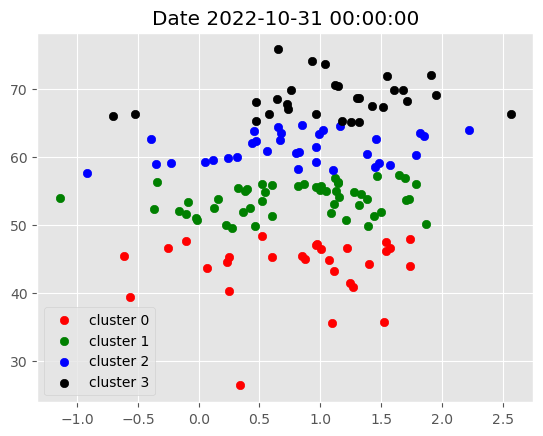

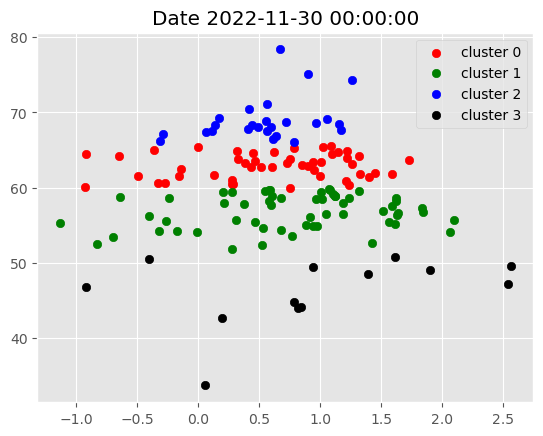

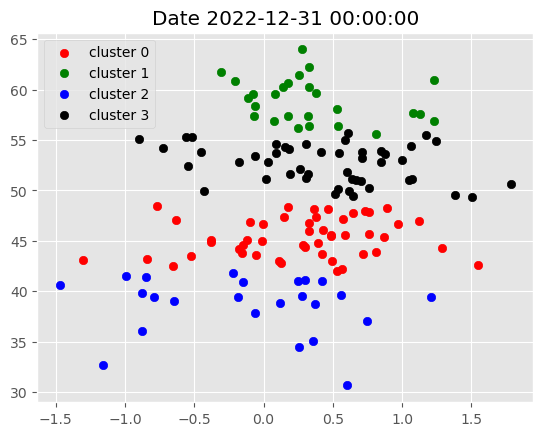

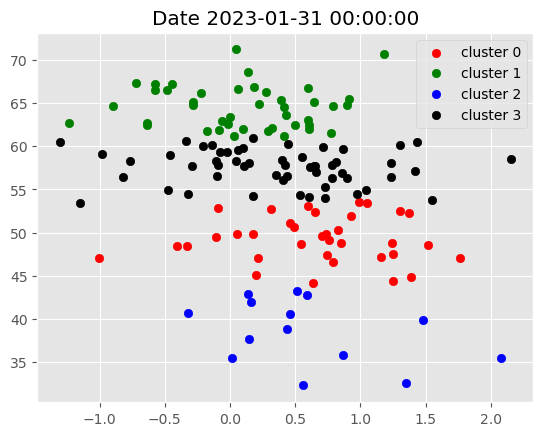

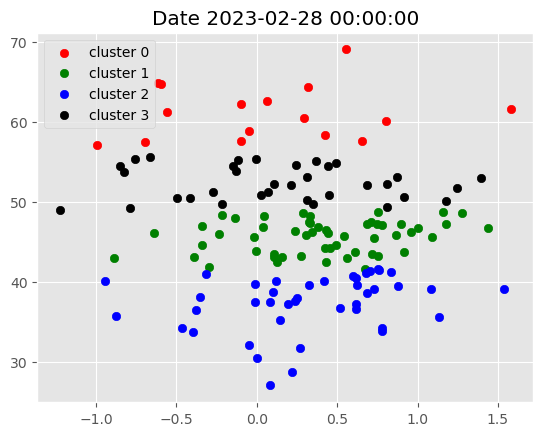

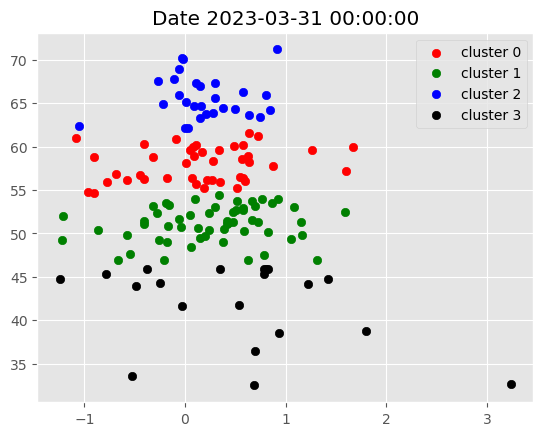

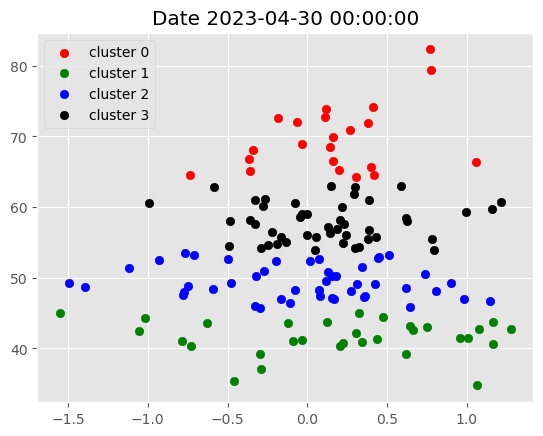

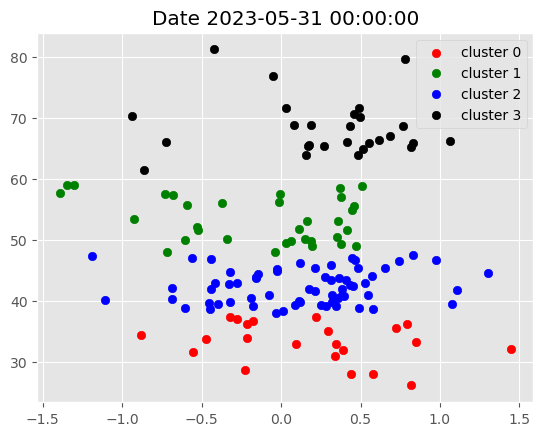

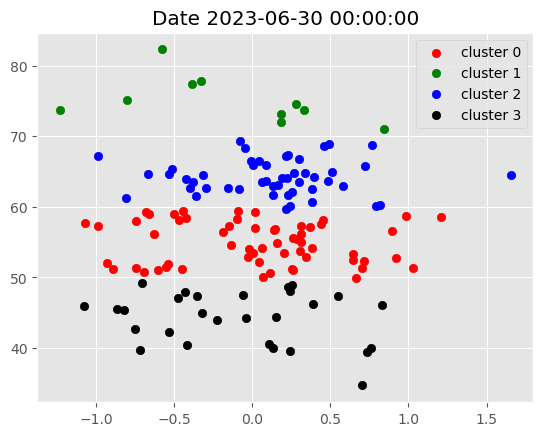

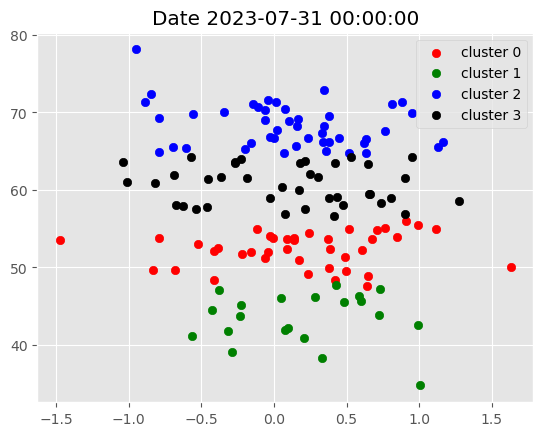

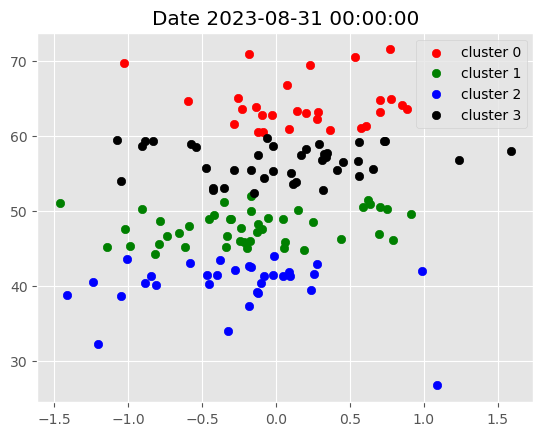

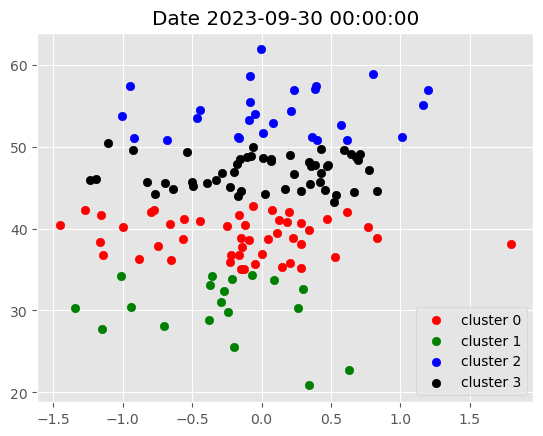

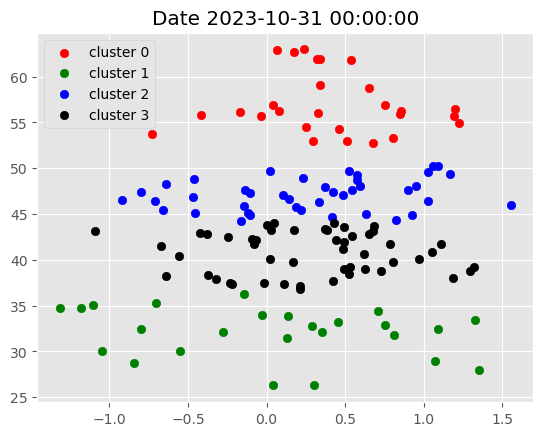

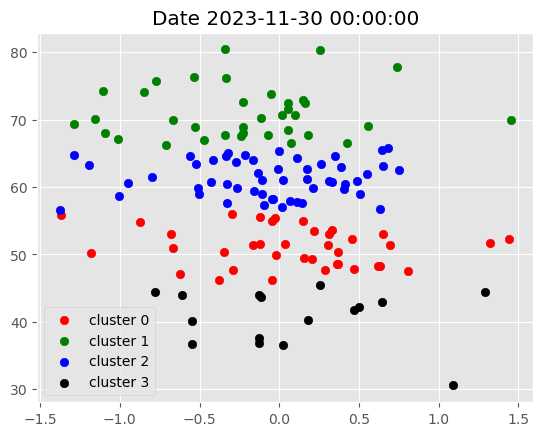

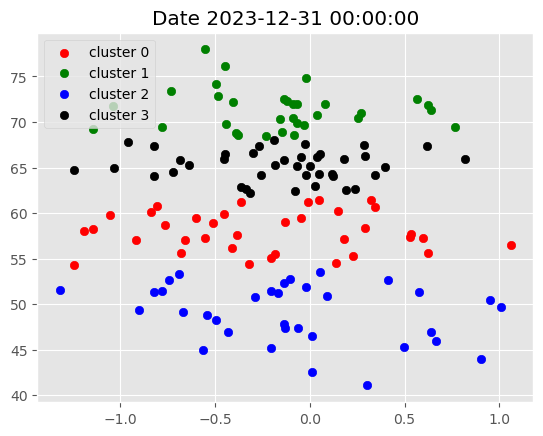

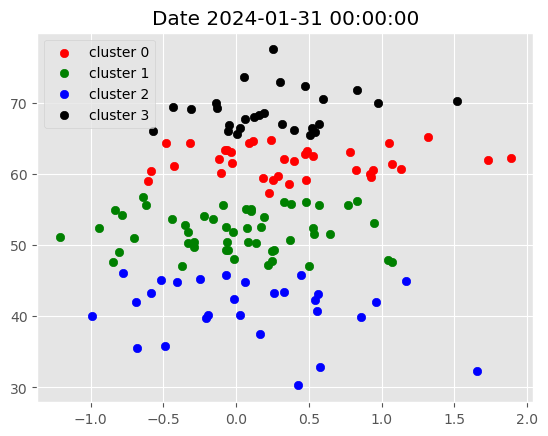

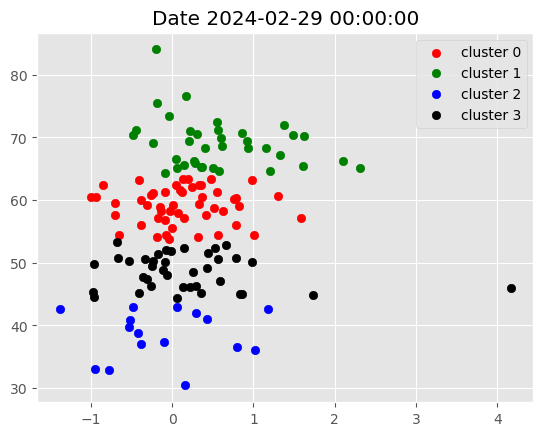

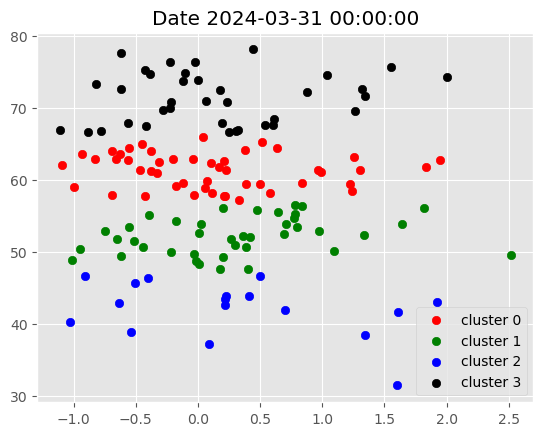

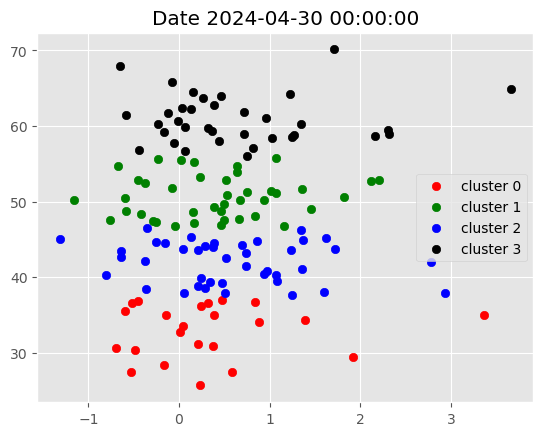

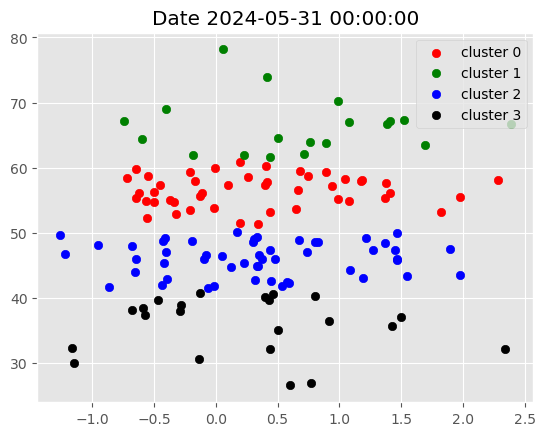

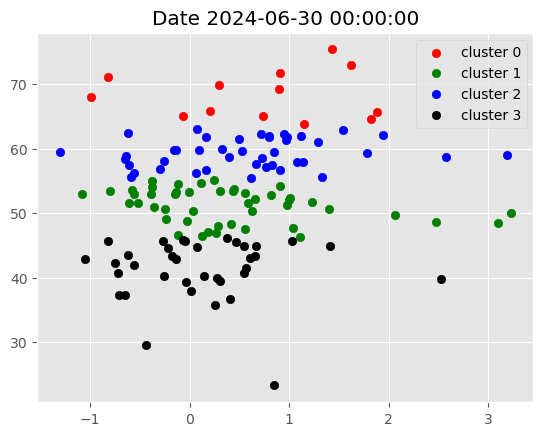

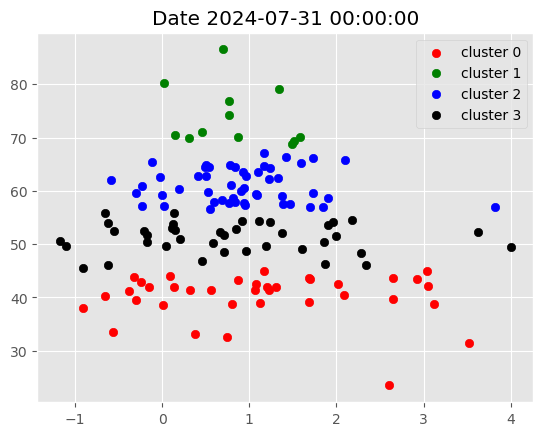

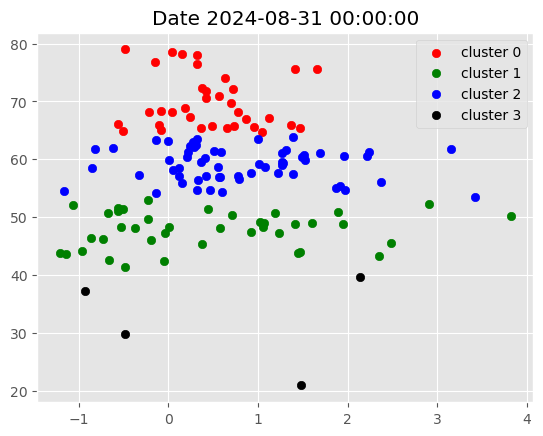

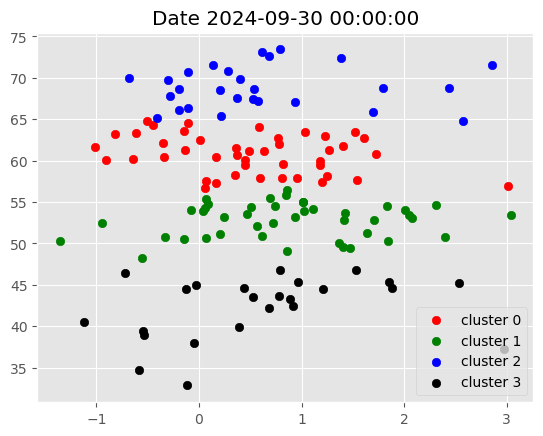

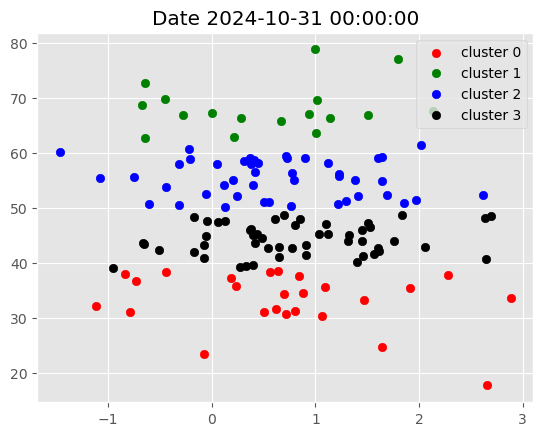

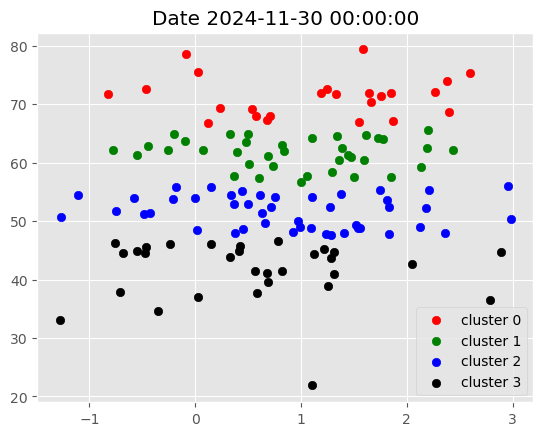

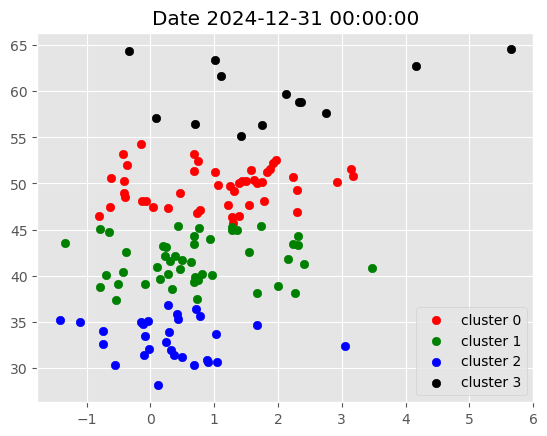

In [146]:
plt.style.use('ggplot')

for i in data.index.get_level_values('Date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)